In [51]:
import os
import zipfile
import numpy as np
import pandas as pd
import duckdb
import lightgbm as lgb
import cvxpy as cp
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss

SEED = 42
np.random.seed(SEED)

DATA_URL = "http://go.criteo.net/criteo-research-attribution-dataset.zip"
ZIP_PATH = "criteo.zip"
DATA_DIR = "criteo_data"
TSV_GZ = os.path.join(DATA_DIR, "criteo_attribution_dataset.tsv.gz")

# sampling sizes
N_TRAIN = 50_000
N_ALLOC = 20_000  # separate slice used for optimization

pd.set_option("display.max_columns", 30)

In [52]:
if not os.path.exists(TSV_GZ):
    if not os.path.exists(ZIP_PATH):
        !wget $DATA_URL -O $ZIP_PATH
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(DATA_DIR)
    # the zip contains the tsv.gz already

assert os.path.exists(TSV_GZ), "Dataset download failed."
print("Data ready:", TSV_GZ)

Data ready: criteo_data/criteo_attribution_dataset.tsv.gz


In [53]:
con = duckdb.connect()
df_raw = con.execute(f"""
    SELECT *
    FROM read_csv_auto('{TSV_GZ}', delim='\t')
    LIMIT {N_TRAIN + N_ALLOC}
""").df()
print(df_raw.shape)
df_raw.head()

(70000, 22)


,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,0.000010,0.390794,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,0.000010,0.059600,423858,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,0.000183,0.149706,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,0.000094,0.154785,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,0.000032,0.037583,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072


In [54]:
df = df_raw.copy()

df["day"] = np.floor(df["timestamp"] / 86400).astype(int)
df["hour"] = ((df["timestamp"] % 86400) // 3600).astype(int)

df["click_pos"] = df["click_pos"].clip(lower=0)
df["click_nb"] = df["click_nb"].clip(lower=0)

df["time_since_last_click"] = df["time_since_last_click"].replace(-1, 1_000_000)

cat_cols = [
    "campaign",
    "cat1","cat2","cat3","cat4","cat5","cat6","cat7","cat8","cat9",
]
for c in cat_cols:
    df[c] = df[c].astype("category")

FEATURES = cat_cols + [
    "click_pos", "click_nb", "time_since_last_click", "day", "hour"
]
LABEL_CTR = "click"
LABEL_CVR = "conversion"

df_model = df.iloc[:N_TRAIN].copy()
df_alloc = df.iloc[N_TRAIN:N_TRAIN+N_ALLOC].copy()

print(df_model[[LABEL_CTR, LABEL_CVR]].mean())

click         0.36482
conversion    0.05288
dtype: float64


# Problem 0: LightGBM Model to get predicted CTR and predicted CVR

In [55]:
train_ctr, valid_ctr = train_test_split(df_model, test_size=0.2, random_state=SEED)
lgb_train_ctr = lgb.Dataset(train_ctr[FEATURES], label=train_ctr[LABEL_CTR], categorical_feature=cat_cols)
lgb_valid_ctr = lgb.Dataset(valid_ctr[FEATURES], label=valid_ctr[LABEL_CTR], categorical_feature=cat_cols)

params_ctr = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
    "seed": SEED,
}

model_ctr = lgb.train(
    params_ctr,
    lgb_train_ctr,
    num_boost_round=300,
    valid_sets=[lgb_train_ctr, lgb_valid_ctr],
    valid_names=["train", "valid"],
)

valid_ctr_pred = model_ctr.predict(valid_ctr[FEATURES])
print("CTR AUC:", roc_auc_score(valid_ctr[LABEL_CTR], valid_ctr_pred))
print("CTR logloss:", log_loss(valid_ctr[LABEL_CTR], valid_ctr_pred))

CTR AUC: 0.7064025126182949
CTR logloss: 0.5788050411781788


In [56]:
train_cvr, valid_cvr = train_test_split(df_model, test_size=0.2, random_state=SEED)
pos_weight = (len(train_cvr) - train_cvr[LABEL_CVR].sum()) / max(train_cvr[LABEL_CVR].sum(), 1)

params_cvr = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
    "seed": SEED,
    "scale_pos_weight": pos_weight,
}

lgb_train_cvr = lgb.Dataset(train_cvr[FEATURES], label=train_cvr[LABEL_CVR], categorical_feature=cat_cols)
lgb_valid_cvr = lgb.Dataset(valid_cvr[FEATURES], label=valid_cvr[LABEL_CVR], categorical_feature=cat_cols)

model_cvr = lgb.train(
    params_cvr,
    lgb_train_cvr,
    num_boost_round=400,
    valid_sets=[lgb_train_cvr, lgb_valid_cvr],
    valid_names=["train", "valid"],
)

valid_cvr_pred = model_cvr.predict(valid_cvr[FEATURES])
print("CVR AUC:", roc_auc_score(valid_cvr[LABEL_CVR], valid_cvr_pred))
print("CVR logloss:", log_loss(valid_cvr[LABEL_CVR], valid_cvr_pred))

CVR AUC: 1.0
CVR logloss: 3.3961117643321374e-08


In [68]:
df_alloc = df_alloc.copy()
df_alloc["pCTR"] = model_ctr.predict(df_alloc[FEATURES])
df_alloc["pCVR"] = model_cvr.predict(df_alloc[FEATURES])
df_alloc = df_alloc[[
    "campaign", "cost", "click", "conversion", "pCTR", "pCVR"
]]

df_alloc["density_cvr"] = df_alloc["pCVR"] / df_alloc["cost"].clip(lower=1e-8)
df_alloc.to_csv("opt_prob4_frame.csv", index=False)
df_alloc.head()

,campaign,cost,click,conversion,pCTR,pCVR,density_cvr
50000,8867068,0.000010,0,0,0.113141,5.131413e-08,0.004985
50001,26091094,0.000102,0,0,0.285584,2.283658e-08,0.000224
50002,18975823,0.000018,0,0,0.272553,3.823654e-08,0.002146
50003,5544859,0.000092,1,1,0.997322,9.999999e-01,10914.044352
50004,5686703,0.000140,0,0,0.193737,3.145542e-08,0.000225


# Helper Functions for Upcoming

In [20]:
def visualize(out):
    plt.figure(figsize=(8, 4))
    plt.bar(out["ad_id"].astype(str), out["weight"], color="#4B71F2")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Traffic share (w)")
    plt.title("Traffic Allocation by Ad")
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(8, 4))
    plt.bar(out["ad_id"].astype(str), out["exp_cost_daily"], color="#00A676")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Daily Spend")
    plt.title("Daily Spend by Ad")
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(8, 4))
    plt.bar(out["ad_id"].astype(str), out["exp_convs"], color="#F28E2B")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Daily Conversions")
    plt.title("Conversions by Ad")
    plt.tight_layout()
    plt.show()


# Let's solve the Easy Problem

In [69]:
sample = df_alloc.sample(10, random_state=0).reset_index(drop=True)
sample["ad_id"] = sample.index + 1

In [13]:
sample

,campaign,cost,click,conversion,pCTR,pCVR,density_cvr,ad_id
0,6228543,0.000811,0,0,0.405566,3.001312e-08,0.000037,1
1,30801593,0.000010,1,0,0.600863,6.602808e-08,0.006579,2
2,25419531,0.000016,0,0,0.091880,5.319139e-08,0.003426,3
3,2576437,0.000010,1,0,0.237900,1.300556e-08,0.001301,4
4,15398570,0.000146,1,0,0.517190,1.395273e-08,0.000096,5
5,12947794,0.000025,0,0,0.214017,1.807523e-08,0.000723,6
6,30801593,0.000011,0,0,0.154085,7.074638e-08,0.006576,7
7,32368244,0.000010,0,0,0.442627,6.657611e-08,0.006658,8
8,14289571,0.000102,1,0,0.443258,9.488829e-09,0.000093,9
9,31772643,0.000038,0,0,0.291282,7.293725e-08,0.001919,10


In [70]:
sample["cost"] = sample["cost"]*1e3

In [71]:
I = 200_000   # total daily impressions across ALL ads

In [72]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt


pCTR = sample["pCTR"].to_numpy()
pCVR = sample["pCVR"].to_numpy()
CPC  = sample["cost"].to_numpy()

# Cost per impression
cpi = pCTR * CPC

# Conversions per impression
conv = pCTR * pCVR

n = len(sample)


In [18]:
min_possible_cost = I * cpi.min()
print("Minimum possible spend:", min_possible_cost)
B = min_possible_cost*1.5

Minimum possible spend: 285.26226428010864


## 1.1

## **Problem 1.1 — Traffic Allocation (Simplex LP)**

We allocate traffic across \(n\) ads using a probability vector  
$$w \in \mathbb{R}^n.$$

### **Optimization Problem**

**Objective: maximize expected conversions**
$$
\max_{w} \; \mathbf{conv}^\top w
$$

**Constraints**
$$
\sum_{i=1}^n w_i = 1, \qquad w_i \ge 0 \;\; \forall i.
$$

### **Formal Definition**
This is a **linear program (LP)** over the **probability simplex**:
- linear objective  
- linear equality constraint  
- linear inequality constraints  

In [73]:
w = cp.Variable(n)



objective = cp.Maximize(
    conv @ w
)

constraints = [
    cp.sum(w) == 1,
    w >= 0,
]

prob = cp.Problem(objective, constraints)
prob.solve()

print("STATUS:", prob.status)
if prob.status != "optimal":
    raise ValueError("Problem infeasible — increase budget or reduce impressions.")
if w.value is None:
    raise ValueError("w is None — solver infeasible or diverged.")


w_opt = np.clip(w.value, 0, None)

out = sample.copy()
out["weight"] = w_opt
out["cpi"] = out["pCTR"] * out["cost"]
# cpc cost per click , pay cost only when it gets clicked

# Expected cost for a single impression
out["exp_cost_impr"] = out["weight"] * out["cpi"]

# Daily totals weight * Total impression * CPI where CPI = pCTR*cost
out["exp_cost_daily"] = I * out["exp_cost_impr"]

# Expected clicks & conversions
out["exp_clicks"] = I * out["pCTR"] * out["weight"]
out["exp_convs"] = I * out["pCTR"] * out["pCVR"] * out["weight"]

print(out.head())


# Per-impression expectation

print("Status:", prob.status)
print("Daily Spend =", out["exp_cost_daily"].sum())
print("Daily Conversions =", out["exp_convs"].sum())

print(
    out[["campaign","pCTR","pCVR","cost","cpi",
         "weight",
         "exp_cost_impr",
         "exp_clicks","exp_convs","exp_cost_daily"]]
)


STATUS: optimal
   campaign      cost  click  conversion      pCTR          pCVR  density_cvr  \
0   6228543  0.810707      0           0  0.405566  3.001312e-08     0.000037   
1  30801593  0.010036      1           0  0.600863  6.602808e-08     0.006579   
2  25419531  0.015524      0           0  0.091880  5.319139e-08     0.003426   
3   2576437  0.010000      1           0  0.237900  1.300556e-08     0.001301   
4  15398570  0.145933      1           0  0.517190  1.395273e-08     0.000096   

   ad_id    weight       cpi  exp_cost_impr  exp_cost_daily     exp_clicks  \
0      1  0.000272  0.328795   8.957197e-05       17.914395      22.097256   
1      2  0.996864  0.006030   6.011053e-03     1202.210562  119795.659037   
2      3  0.000216  0.001426   3.084944e-07        0.061699       3.974533   
3      4  0.000207  0.002379   4.934332e-07        0.098687       9.868663   
4      5  0.000230  0.075475   1.736583e-05        3.473167      23.799680   

      exp_convs  
0  6.63207

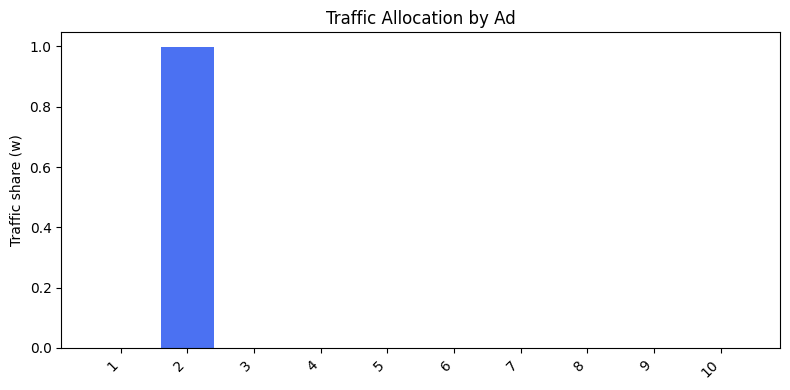

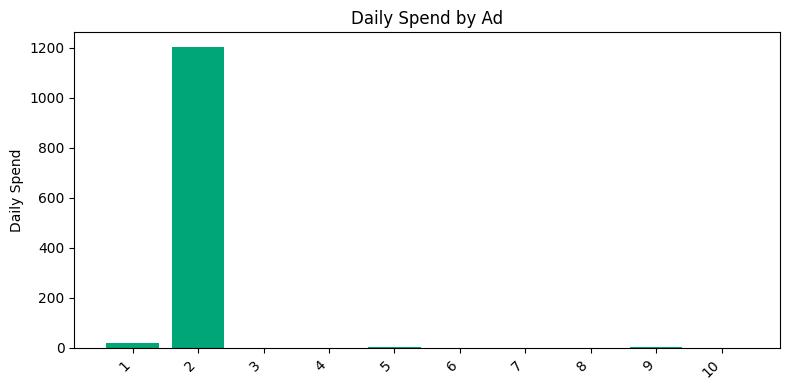

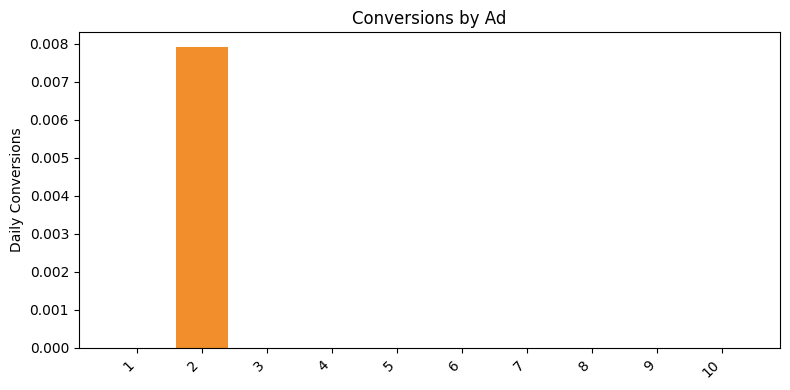

In [21]:
visualize(out)

## 1.2

## **Problem 1.2 — Traffic Allocation with Per-Ad Cap**

We allocate traffic across \(n\) ads using a weight vector  
$$w \in \mathbb{R}^n.$$

The goal is to maximize expected conversions while ensuring:
- weights sum to 1,
- no negative weights,
- no ad receives more than a fixed cap \( \text{cap} \).

---

### **Optimization Problem**

**Objective:**
$$
\max_{w} \; \mathbf{conv}^\top w
$$

**Constraints:**
$$
\sum_{i=1}^n w_i = 1,
\qquad
0 \le w_i \le \text{cap} \quad \forall i.
$$

---

### **Problem Type**

This is a **bounded linear program (LP)**:
- linear objective  
- linear equality constraint  
- linear box constraints \(0 \le w_i \le \text{cap}\)

Feasible region = **intersection of a simplex and a hypercube**.

In [74]:
w = cp.Variable(n)

cap = 0.4

objective = cp.Maximize(
    conv @ w,
)

constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= cap,
]

prob = cp.Problem(objective, constraints)
prob.solve()

print("STATUS:", prob.status)
if prob.status != "optimal":
    raise ValueError("Problem infeasible — increase budget or reduce impressions.")
if w.value is None:
    raise ValueError("w is None — solver infeasible or diverged.")


w_opt = np.clip(w.value, 0, None)

out = sample.copy()
out["weight"] = w_opt
out["cpi"] = out["pCTR"] * out["cost"]
out["exp_cost_impr"] = out["weight"] * out["cpi"]
out["exp_cost_daily"] = I * out["exp_cost_impr"]
out["exp_clicks"] = I * out["pCTR"] * out["weight"]
out["exp_convs"] = I * out["pCTR"] * out["pCVR"] * out["weight"]
print("Status:", prob.status)
print("Daily Spend =", out["exp_cost_daily"].sum())
print("Daily Conversions =", out["exp_convs"].sum())

print(
    out[["campaign","pCTR","pCVR","cost","cpi",
         "weight",
         "exp_cost_impr",
         "exp_clicks","exp_convs","exp_cost_daily"]]
)


STATUS: optimal
Status: optimal
Daily Spend = 3190.3906287964764
Daily Conversions = 0.006031578528735719
   campaign      pCTR          pCVR      cost       cpi    weight  \
0   6228543  0.405566  3.001312e-08  0.810707  0.328795  0.026820   
1  30801593  0.600863  6.602808e-08  0.010036  0.006030  0.393002   
2  25419531  0.091880  5.319139e-08  0.015524  0.001426  0.012877   
3   2576437  0.237900  1.300556e-08  0.010000  0.002379  0.011170   
4  15398570  0.517190  1.395273e-08  0.145933  0.075475  0.015814   
5  12947794  0.214017  1.807523e-08  0.025003  0.005351  0.011859   
6  30801593  0.154085  7.074638e-08  0.010758  0.001658  0.023118   
7  32368244  0.442627  6.657611e-08  0.010000  0.004426  0.389329   
8  14289571  0.443258  9.488829e-09  0.102044  0.045232  0.012181   
9  31772643  0.291282  7.293725e-08  0.038009  0.011071  0.103831   

   exp_cost_impr    exp_clicks  exp_convs  exp_cost_daily  
0       0.008818   2175.414489   0.000065     1763.623209  
1       0.0023

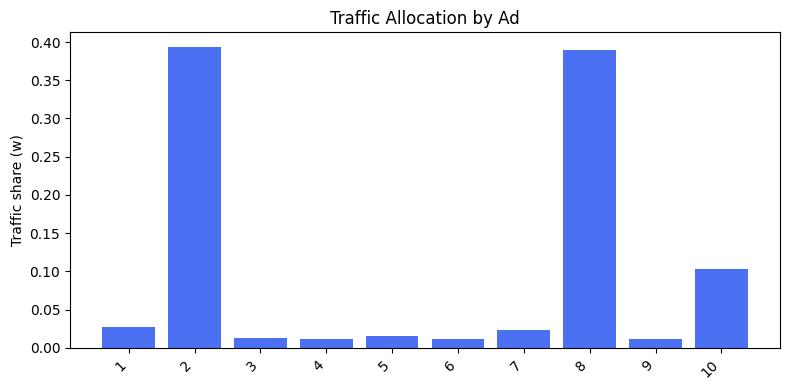

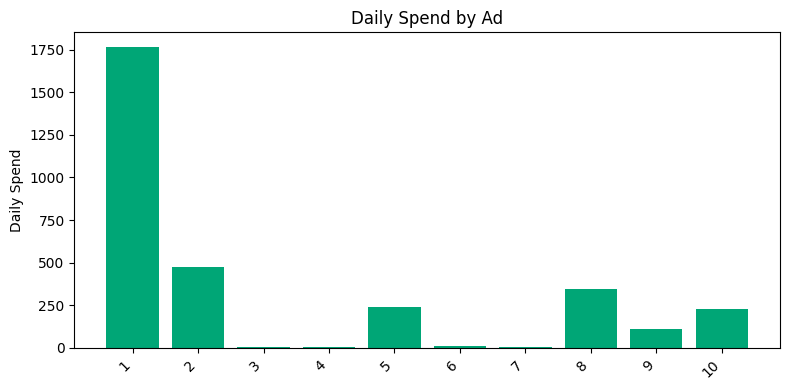

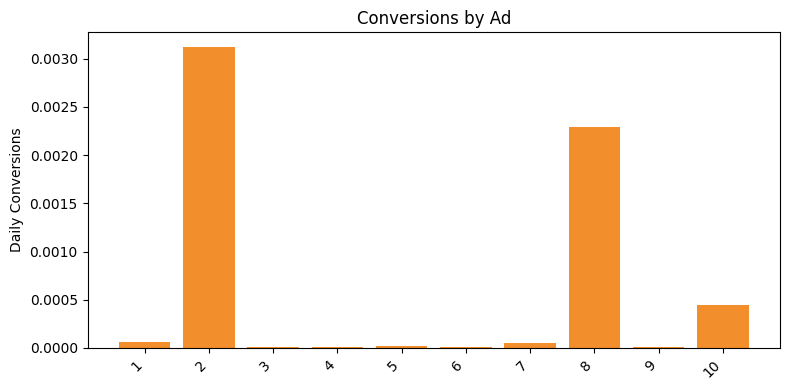

In [23]:
visualize(out)

## 1.3 - Not considering conv, adding exploration, not adding a budget limit

In [79]:
min_possible_cost = I * cpi.min()
print("Minimum possible spend:", min_possible_cost)
B = min_possible_cost*1.5

Minimum possible spend: 285.26226428010864


## **Problem 1.3 — Entropy-Regularized Traffic Allocation with Per-Ad Cap**

We allocate traffic across \(n\) ads using a weight vector  
$$ w \in \mathbb{R}^n. $$

---

### **Optimization Problem**

**Objective**
$$
\max_{w} \; pCTR^\top w \;+\; \gamma \sum_{i=1}^n \mathrm{entr}(w_i)
$$

where
$$
\mathrm{entr}(w_i) = w_i \log\!\left(\frac{1}{w_i}\right)
$$
is the negative entropy.

**Constraints**
$$
\sum_{i=1}^n w_i = 1, 
\qquad
0 \le w_i \le \text{cap} \quad \forall i.
$$

---

### **Problem Type**
A **convex optimization problem**: linear objective + concave entropy regularizer + linear constraints over a capped simplex.


In [94]:
w = cp.Variable(n)

alpha = 0.3 # not being used in current formulation
gamma = 0.7
cap = 0.4

I = 200_000

objective = cp.Maximize(
    # conv @ w +
    # alpha (pCTR @ w) +
    pCTR @ w +
    gamma * cp.sum(cp.entr(w))
)

constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= cap,
    # I * (cpi @ w) <= B
]

prob = cp.Problem(objective, constraints)
prob.solve()

print("STATUS:", prob.status)
if prob.status != "optimal":
    raise ValueError("Problem infeasible — increase budget or reduce impressions.")
if w.value is None:
    raise ValueError("w is None — solver infeasible or diverged.")


w_opt = np.clip(w.value, 0, None)

STATUS: optimal


In [95]:
# Clip tiny numerical noise (everything < 1e-6)
EPS = 1e-6

out = sample.copy()
out["weight"] = np.where(w_opt < EPS, 0, w_opt)

out["cpi"] = out["pCTR"] * out["cost"]

out["exp_cost_impr"] = out["weight"] * out["cpi"]

out["impressions"] = (I * out["weight"]).round().astype(int)
out["exp_cost_daily"] = I * out["exp_cost_impr"]
out["exp_clicks"] = I * out["pCTR"] * out["weight"]
out["exp_convs"] = I * out["pCTR"] * out["pCVR"] * out["weight"]
def fmt(x):
    return f"{x:,.4f}"

pretty = out.copy()
pretty["weight"] = pretty["weight"].map(lambda x: f"{x:.4f}")
pretty["pCTR"]   = pretty["pCTR"].map(lambda x: f"{x:.4f}")
pretty["pCVR"]   = pretty["pCVR"].map(lambda x: f"{x:.8f}")
pretty["cpi"]    = pretty["cpi"].map(lambda x: f"{x:.6f}")
pretty["exp_cost_impr"] = pretty["exp_cost_impr"].map(fmt)
pretty["exp_cost_daily"] = pretty["exp_cost_daily"].map(lambda x: f"{x:,.2f}")
pretty["exp_clicks"] = pretty["exp_clicks"].map(lambda x: f"{x:,.2f}")
pretty["exp_convs"] = pretty["exp_convs"].map(lambda x: f"{x:,.4f}")


In [96]:
cols = [
    "ad_id","campaign","pCTR","pCVR","cost","cpi",
    "weight","impressions",
    "exp_clicks","exp_convs","exp_cost_daily"
]

print("\n=== OPTIMIZED AD BUDGET ALLOCATION ===\n")
print(pretty[cols].to_string(index=False))

print("\n=== DAILY TOTALS ===")
# print(f"Budget Limit    : {B:,.2f}")
print(f"Daily Spend     : {out['exp_cost_daily'].sum():,.2f}")
print(f"Expected Clicks : {out['exp_clicks'].sum():,.2f}")
print(f"Expected Convs  : {out['exp_convs'].sum():,.4f}")



=== OPTIMIZED AD BUDGET ALLOCATION ===

 ad_id campaign   pCTR       pCVR     cost      cpi weight  impressions exp_clicks exp_convs exp_cost_daily
     1  6228543 0.4056 0.00000003 0.810707 0.328795 0.1071        21417   8,686.07    0.0003       7,041.85
     2 30801593 0.6009 0.00000007 0.010036 0.006030 0.1416        28311  17,011.16    0.0011         170.72
     3 25419531 0.0919 0.00000005 0.015524 0.001426 0.0684        13682   1,257.10    0.0001          19.51
     4  2576437 0.2379 0.00000001 0.010000 0.002379 0.0843        16855   4,009.71    0.0001          40.10
     5 15398570 0.5172 0.00000001 0.145933 0.075475 0.1256        25120  12,991.55    0.0002       1,895.90
     6 12947794 0.2140 0.00000002 0.025003 0.005351 0.0814        16289   3,486.09    0.0001          87.16
     7 30801593 0.1541 0.00000007 0.010758 0.001658 0.0748        14951   2,303.70    0.0002          24.78
     8 32368244 0.4426 0.00000007 0.010000 0.004426 0.1129        22583   9,995.76    0.0007   

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import pandas as pd

def plot_traffic_over_gamma(gamma_values, sample_df, pCTR_arr, n_ads, cap_value, epsilon=1e-6):
    for g in gamma_values:
        w = cp.Variable(n_ads)

        objective = cp.Maximize(pCTR_arr @ w + g * cp.sum(cp.entr(w)))

        constraints = [
            cp.sum(w) == 1,
            w >= 0,
            w <= cap_value,
        ]

        prob = cp.Problem(objective, constraints)
        prob.solve()

        if prob.status == "optimal":
            w_opt = np.where(w.value < epsilon, 0, w.value)

            # Prepare data for bar plot
            plot_data = pd.DataFrame({
                'ad_id': sample_df['ad_id'].astype(str),
                'weight': w_opt
            })

            plt.figure(figsize=(8, 5))
            plt.bar(plot_data['ad_id'], plot_data['weight'], color='#4B71F2')
            plt.xticks(rotation=45, ha="right")
            plt.ylabel("Traffic Share (w)")
            plt.title(f'Traffic Allocation by Ad for Gamma = {g:.2f}')
            plt.tight_layout()
            plt.show()
        else:
            print(f"Problem for gamma={g} was not optimal: {prob.status}")


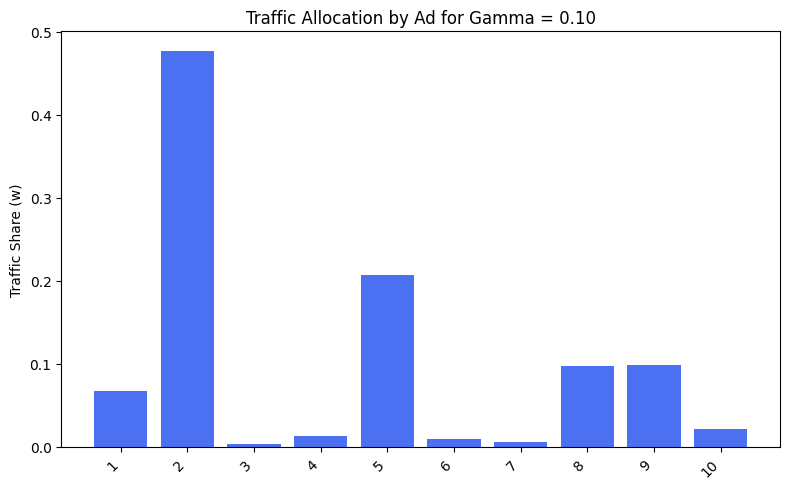

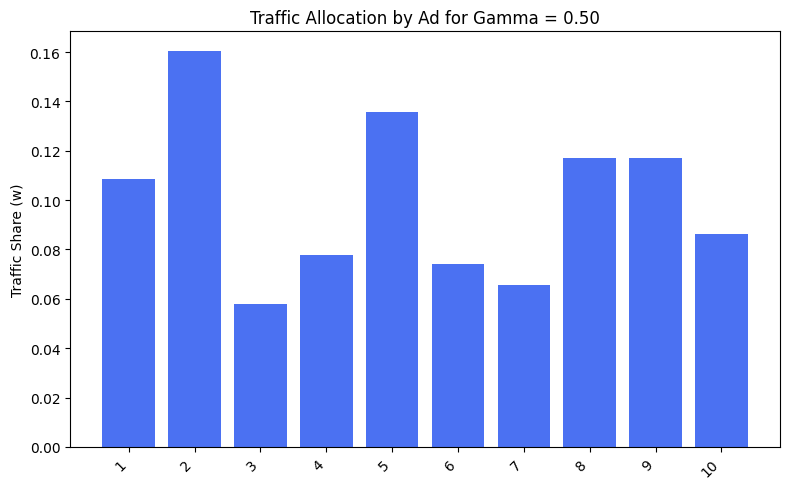

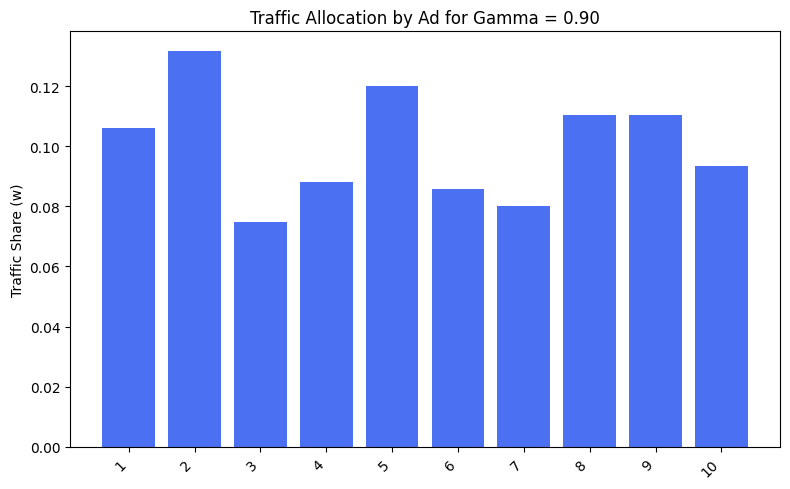

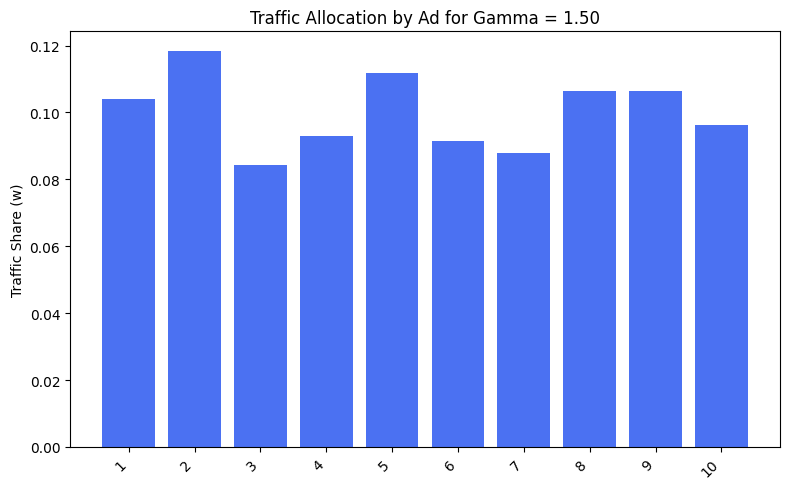

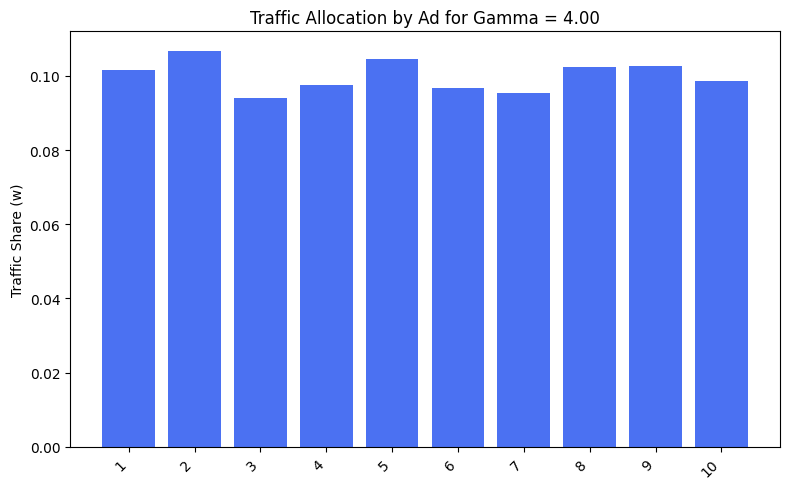

In [106]:
plot_traffic_over_gamma([0.1,0.5,0.9,1.5, 4], sample, pCTR, 10, 0.5)

## 1.4 Figuring out formulation with CPI and Budget constraint too!

## **Problem — Budgeted Entropy-Regularized Impression Allocation**

We choose impressions 
$$ x \in \mathbb{R}^n $$
across $n$ ads.


---

### **Objective**

Maximize expected clicks with entropy regularization:

$$
\max_{x} \;\; 
\sum_{i=1}^n pCTR_i \, x_i
\;+\;
\gamma \sum_{i=1}^n \mathrm{entr}(x_i)
$$

where  

$$
\mathrm{entr}(x_i) = x_i \log\!\left(\frac{1}{x_i}\right)
$$

encourages diversification.

---

### **Constraints**

**Nonnegativity**
$$
x_i \ge 0 \quad \forall i.
$$

**Total impression limit**
$$
\sum_{i=1}^n x_i \le I.
$$

**Budget constraint**
$$
\sum_{i=1}^n (pCTR_i \cdot CPC_i) \, x_i \le B.
$$

**Optional per-ad cap**
$$
x_i \le \text{cap} \cdot I \quad \forall i.
$$

---

### **Problem Type**
A **convex optimization problem** with a linear objective plus concave entropy regularizer under linear constraints (budget, simplex mass, box bounds).

In [124]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

def run_allocation(sample, gamma=0.5, cap=None, B=50_000, I=200_000):

    pCTR = sample["pCTR"].to_numpy().reshape(-1)
    CPC  = sample["cost"].to_numpy().reshape(-1)
    cpi  = pCTR * CPC
    n = len(pCTR)

    # Prevent ads from appearing "free"
    CPI_FLOOR = 1e-3
    cpi_tilde = np.maximum(cpi, CPI_FLOOR)

    # Decision var: impressions per ad
    x = cp.Variable(n)

    # Objective: clicks + entropy
    clicks_term = cp.sum(cp.multiply(pCTR, x))
    entropy_term = cp.sum(cp.entr(x + 1e-12))
    objective = cp.Maximize(clicks_term + gamma * entropy_term)

    # Constraints
    constraints = [
        x >= 0,
        cp.sum(x) <= I,
        cp.sum(cp.multiply(cpi_tilde, x)) <= B
    ]
    if cap is not None:
        constraints.append(x <= cap * I)

    prob = cp.Problem(objective, constraints)
    prob.solve()

    if prob.status != "optimal":
        raise ValueError("Optimization failed: " + prob.status)

    x_opt = np.maximum(x.value, 0)

    # Build output table
    out = sample.copy()
    out["den"] = out["pCTR"] / out["cost"]
    out["impressions"] = x_opt
    out["exp_clicks"] = out["impressions"] * out["pCTR"]
    out["exp_cost"] = out["impressions"] * cpi_tilde

    total_cost = out["exp_cost"].sum()
    total_clicks = out["exp_clicks"].sum()

    return out, total_cost, total_clicks


In [125]:
def plot_allocation(out, gamma):
    plt.figure(figsize=(12, 6))
    plt.bar(out["ad_id"].astype(str), out["impressions"])
    plt.xlabel("Ad ID")
    plt.ylabel("Allocated Impressions")
    plt.title(f"Traffic Allocation (gamma = {gamma})")
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.scatter(out["pCTR"], out["impressions"], s=80)
    plt.xlabel("pCTR")
    plt.ylabel("Impressions")
    plt.title(f"CTR vs Impressions (gamma = {gamma})")
    plt.grid(True, alpha=0.3)
    plt.show()


Gamma = 0.0
Total Spend = 1205.9937
Total Clicks = 120172.5200
   ad_id      pCTR      cost        den    impressions     exp_clicks  \
0      1  0.405566  0.810707   0.500262       0.001764       0.000716   
1      2  0.600863  0.010036  59.873649  199999.982431  120172.513095   
2      3  0.091880  0.015524   5.918779       0.000689       0.000063   
3      4  0.237900  0.010000  23.790018       0.000955       0.000227   
4      5  0.517190  0.145933   3.544013       0.005961       0.003083   
5      6  0.214017  0.025003   8.559682       0.000897       0.000192   
6      7  0.154085  0.010758  14.323270       0.000780       0.000120   
7      8  0.442627  0.010000  44.262729       0.002447       0.001083   
8      9  0.443258  0.102044   4.343792       0.002435       0.001079   
9     10  0.291282  0.038009   7.663479       0.001120       0.000326   

       exp_cost  
0  5.801227e-04  
1  1.205992e+03  
2  9.827173e-07  
3  2.272440e-06  
4  4.498904e-04  
5  4.799937e-06  
6  1.29

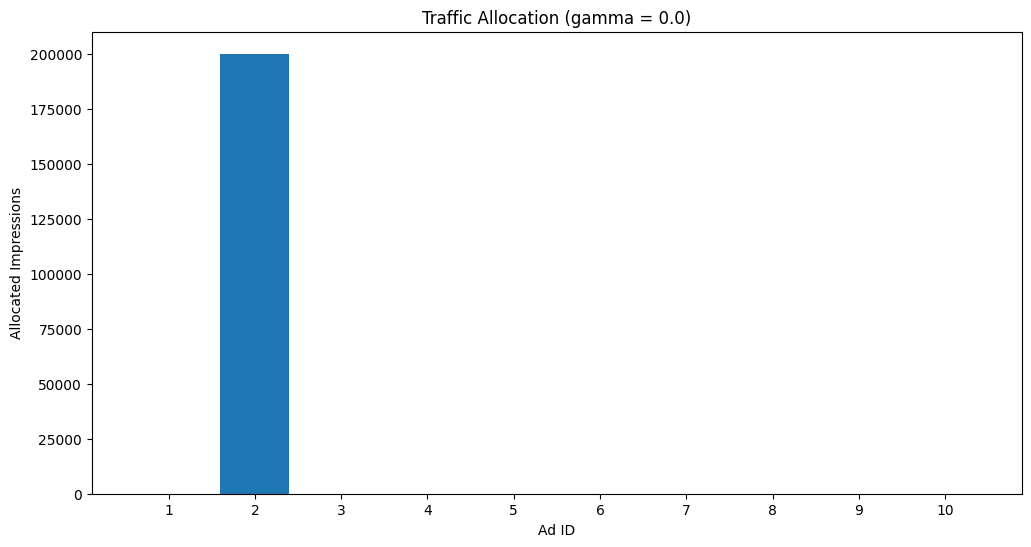

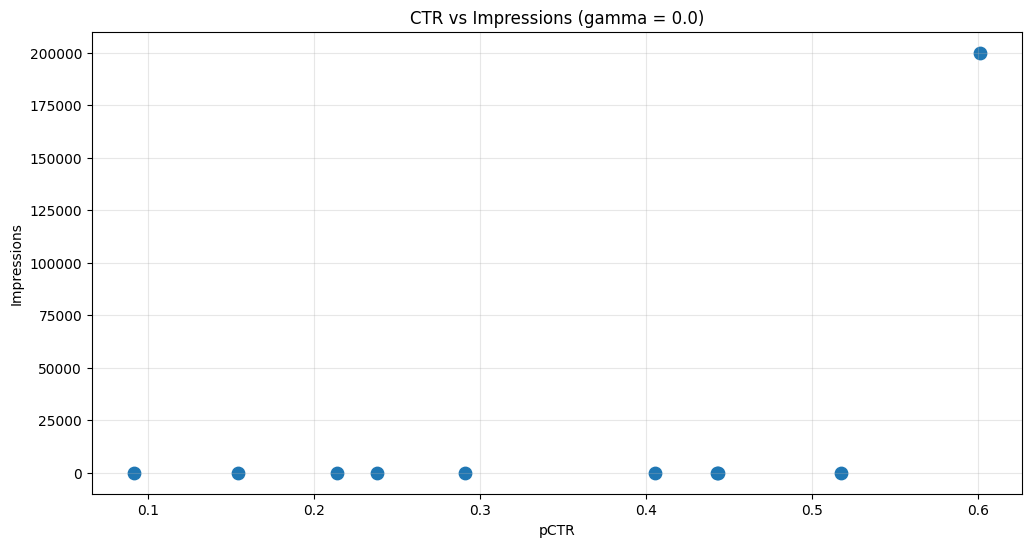

Gamma = 0.2
Total Spend = 1.5281
Total Clicks = 12.2563
   ad_id      pCTR      cost        den  impressions  exp_clicks  exp_cost
0      1  0.405566  0.810707   0.500262     2.794984    1.133549  0.918976
1      2  0.600863  0.010036  59.873649     7.421200    4.459122  0.044750
2      3  0.091880  0.015524   5.918779     0.582401    0.053511  0.000831
3      4  0.237900  0.010000  23.790018     1.208748    0.287561  0.002876
4      5  0.517190  0.145933   3.544013     4.883948    2.525927  0.368617
5      6  0.214017  0.025003   8.559682     1.072649    0.229565  0.005740
6      7  0.154085  0.010758  14.323270     0.794909    0.122483  0.001318
7      8  0.442627  0.010000  44.262729     3.364061    1.489025  0.014890
8      9  0.443258  0.102044   4.343792     3.374495    1.495772  0.152635
9     10  0.291282  0.038009   7.663479     1.578364    0.459750  0.017475

=== ACTIONABLE AD-ALLOCATION RECOMMENDATIONS ===
- Ad 1.0 → allocate 2.7949838989275437 impressions/day → expected 1.1

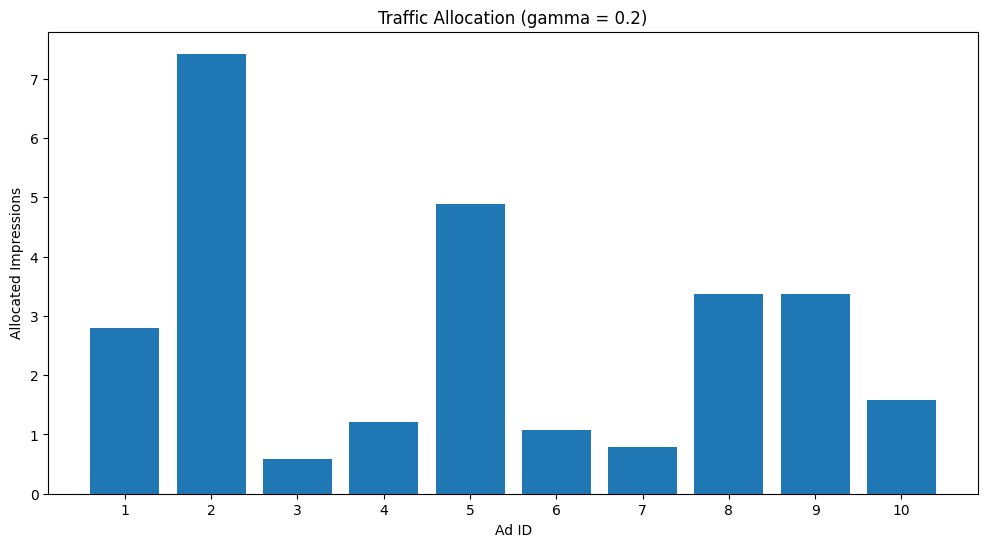

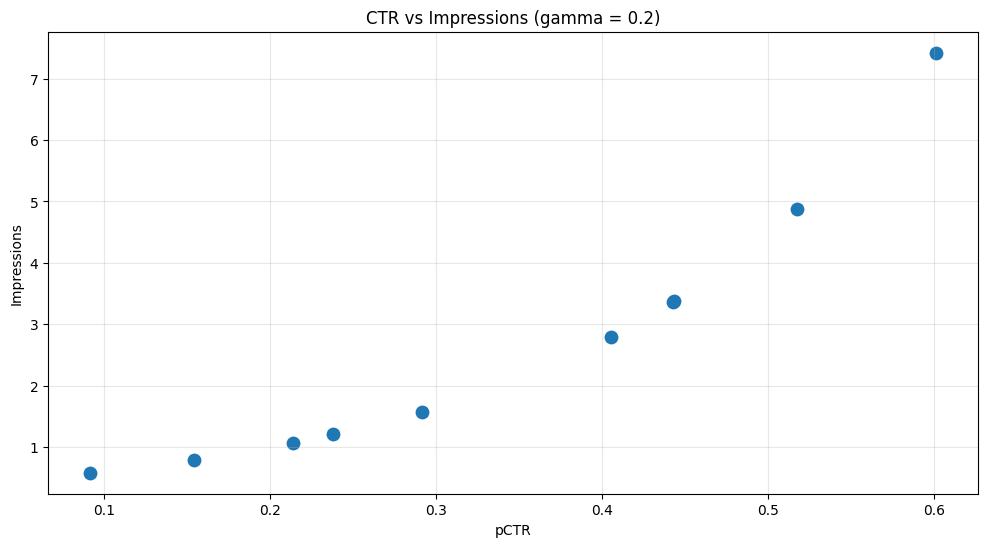

Gamma = 0.5
Total Spend = 0.4152
Total Clicks = 2.9679
   ad_id      pCTR      cost        den  impressions  exp_clicks  exp_cost
0      1  0.405566  0.810707   0.500262     0.827900    0.335768  0.272209
1      2  0.600863  0.010036  59.873649     1.223508    0.735160  0.007378
2      3  0.091880  0.015524   5.918779     0.442091    0.040620  0.000631
3      4  0.237900  0.010000  23.790018     0.592012    0.140840  0.001408
4      5  0.517190  0.145933   3.544013     1.035012    0.535298  0.078118
5      6  0.214017  0.025003   8.559682     0.564454    0.120803  0.003020
6      7  0.154085  0.010758  14.323270     0.500648    0.077142  0.000830
7      8  0.442627  0.010000  44.262729     0.891574    0.394635  0.003946
8      9  0.443258  0.102044   4.343792     0.892733    0.395711  0.040380
9     10  0.291282  0.038009   7.663479     0.658756    0.191884  0.007293

=== ACTIONABLE AD-ALLOCATION RECOMMENDATIONS ===
- Ad 1.0 → allocate 0.8279003260436363 impressions/day → expected 0.34

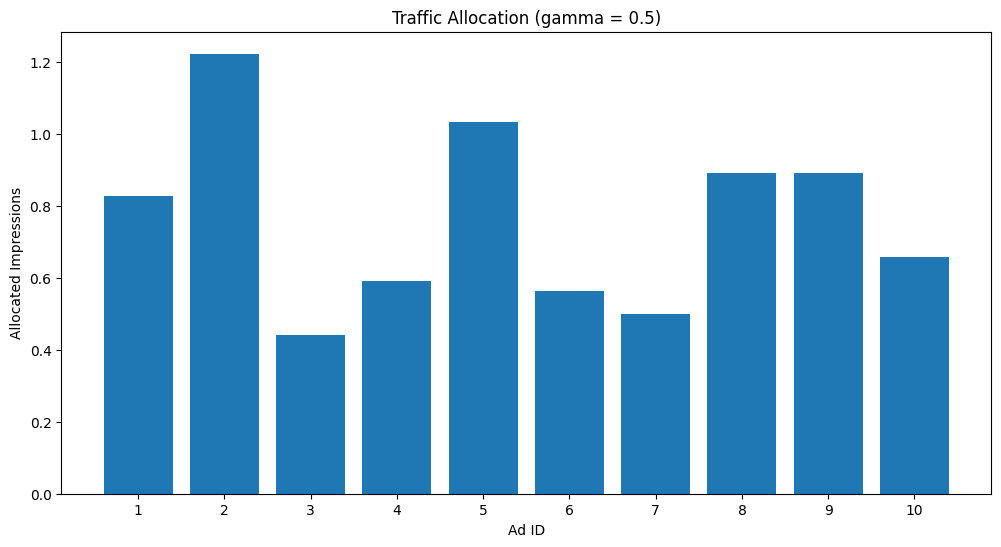

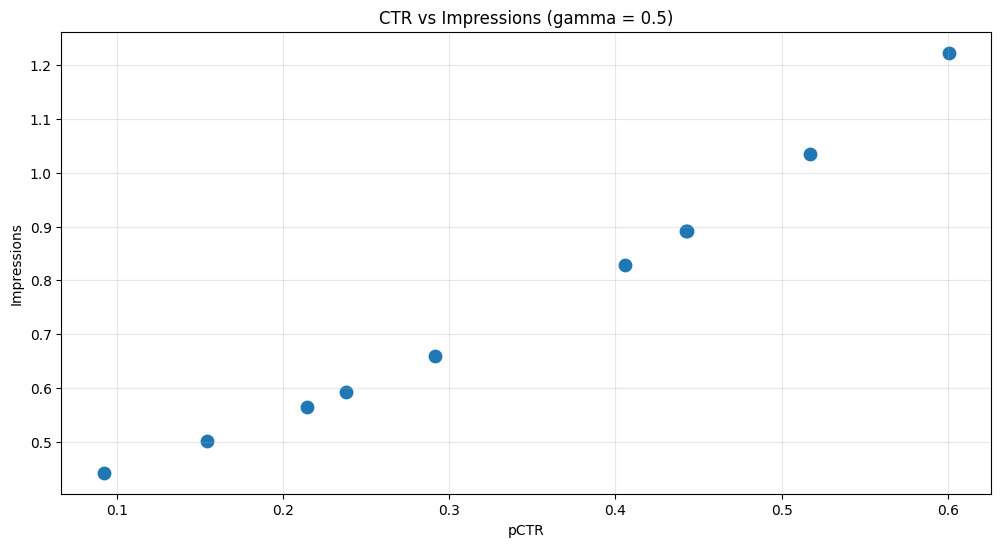

Gamma = 3.0
Total Spend = 0.2041
Total Clicks = 1.4365
   ad_id      pCTR      cost        den  impressions  exp_clicks  exp_cost
0      1  0.405566  0.810707   0.500262     0.421123    0.170793  0.138463
1      2  0.600863  0.010036  59.873649     0.449446    0.270055  0.002710
2      3  0.091880  0.015524   5.918779     0.379312    0.034851  0.000541
3      4  0.237900  0.010000  23.790018     0.398231    0.094739  0.000947
4      5  0.517190  0.145933   3.544013     0.437086    0.226057  0.032989
5      6  0.214017  0.025003   8.559682     0.395073    0.084552  0.002114
6      7  0.154085  0.010758  14.323270     0.387259    0.059671  0.000642
7      8  0.442627  0.010000  44.262729     0.426352    0.188715  0.001887
8      9  0.443258  0.102044   4.343792     0.426442    0.189024  0.019289
9     10  0.291282  0.038009   7.663479     0.405376    0.118079  0.004488

=== ACTIONABLE AD-ALLOCATION RECOMMENDATIONS ===
- Ad 1.0 → allocate 0.42112308965366474 impressions/day → expected 0.1

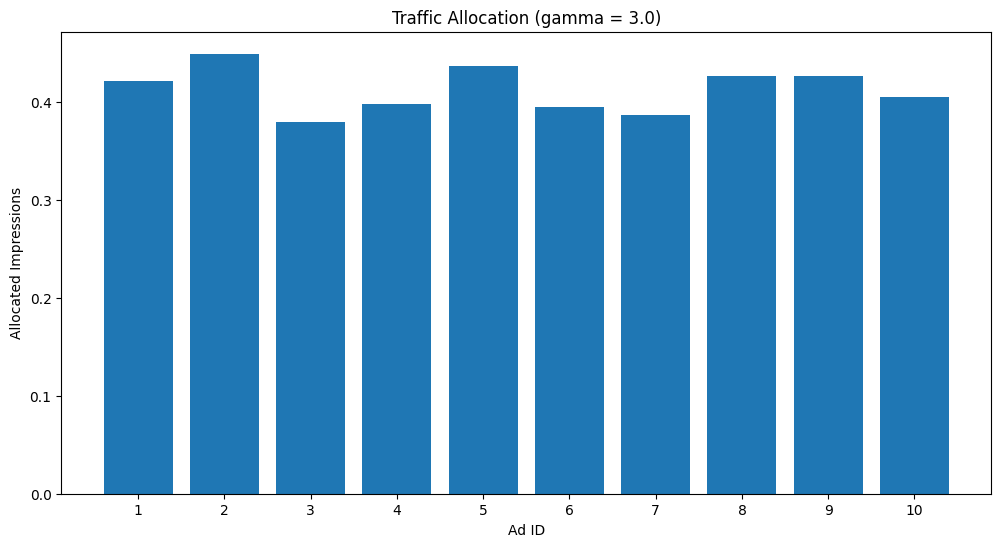

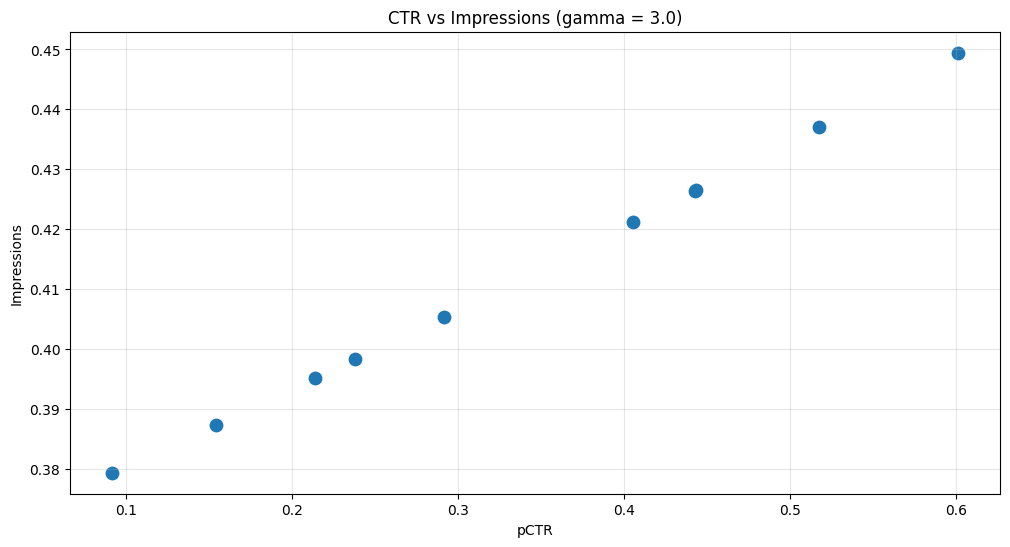

In [131]:
gammas = [0.0, 0.2, 0.5, 3.0]
results = {}

for g in gammas:
    out, cost_used, clicks = run_allocation(sample, gamma=g, B=50_000, I=200_000)
    results[g] = (out, cost_used, clicks)
    print("="*60)
    print(f"Gamma = {g}")
    print(f"Total Spend = {cost_used:.4f}")
    print(f"Total Clicks = {clicks:.4f}")
    print(out[["ad_id", "pCTR", "cost", "den", "impressions", "exp_clicks", "exp_cost"]])
    print("\n=== ACTIONABLE AD-ALLOCATION RECOMMENDATIONS ===")
    for _, r in out.iterrows():
        if r["impressions"] == 0:
            print(f"- Ad {r['ad_id']} gets 0 impressions (low CTR/low value).")
        else:
            print(
                f"- Ad {r['ad_id']} → allocate {r['impressions']:,} impressions/day "
                f"→ expected {r['exp_clicks']:.2f} clicks/"
                f"spend ₹{r['exp_cost']:.2f}."
            )

    plot_allocation(out, g)


## 1.5 Discarded, ucb doesn't make sense for one day allocations, please ignore

## 1.6

In [141]:
sample

,campaign,cost,click,conversion,pCTR,pCVR,density_cvr,ad_id
0,6228543,0.810707,0,0,0.405566,3.001312e-08,0.000037,1
1,30801593,0.010036,1,0,0.600863,6.602808e-08,0.006579,2
2,25419531,0.015524,0,0,0.091880,5.319139e-08,0.003426,3
3,2576437,0.010000,1,0,0.237900,1.300556e-08,0.001301,4
4,15398570,0.145933,1,0,0.517190,1.395273e-08,0.000096,5
5,12947794,0.025003,0,0,0.214017,1.807523e-08,0.000723,6
6,30801593,0.010758,0,0,0.154085,7.074638e-08,0.006576,7
7,32368244,0.010000,0,0,0.442627,6.657611e-08,0.006658,8
8,14289571,0.102044,1,0,0.443258,9.488829e-09,0.000093,9
9,31772643,0.038009,0,0,0.291282,7.293725e-08,0.001919,10


In [143]:
from google.colab import files
sample.to_csv("sample.csv", index=False)
files.download("sample.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [226]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

np.random.seed(42)  # for reproducibility

# 1) Create synthetic ad dataset


def make_synthetic_ads(n_ads=10):
    ad_ids = np.arange(1, n_ads + 1)
    # True CTRs: some good, some bad
    true_ctr = np.random.uniform(0.01, 0.2, size=n_ads)  # 1% to 20%
    # Costs per click: random but reasonable
    cpc = np.random.uniform(0.5, 2.0, size=n_ads)

    df = pd.DataFrame({
        "ad_id": ad_ids,
        "true_ctr": true_ctr,
        "cpc": cpc,
    })
    return df

# let's give a few ads very high ctr
sample = make_synthetic_ads(n_ads=10)
sample.loc[sample["ad_id"] == 2, "true_ctr"] = 0.4
sample.loc[sample["ad_id"] == 3, "true_ctr"] = 0.35
sample.loc[sample["ad_id"] == 5, "true_ctr"] = 0.7
sample.loc[sample["ad_id"] == 5, "cpc"] = 3 # very high ctr but need to allocate lot of budget

In [227]:
sample

,ad_id,true_ctr,cpc
0,1,0.081163,0.530877
1,2,0.400000,1.954865
2,3,0.350000,1.748664
3,4,0.123745,0.818509
4,5,0.700000,3.000000
5,6,0.039639,0.775107
6,7,0.021036,0.956363
7,8,0.174573,1.287135
8,9,0.124212,1.147918
9,10,0.144534,0.936844


In [217]:
2_000 * 0.35 * 1.7

1190.0

## **CTR Estimation, UCB Bonus, and Click Simulation (per day)**

### **1. Empirical CTR Estimate**

For each ad \(i\), let:

- total impressions so far:  
  $$
  N_i
  $$

- total clicks so far:  
  $$
  C_i
  $$

The empirical CTR estimate is:
$$
\widehat{CTR}_i =
\begin{cases}
\dfrac{C_i}{N_i}, & N_i > 0, \\[6pt]
\mu_{\text{prior}}, & N_i = 0,
\end{cases}
$$

where \(\mu_{\text{prior}}\) is the global mean CTR used as the initial prior.

---

### **2. UCB Exploration Bonus**

At day \(t\), the uncertainty / exploration term is:

$$
UCB_i
=
\sqrt{
\frac{\ln(t+1)}{N_i + 1}
}.
$$

This makes ads with fewer impressions receive a larger exploratory bonus.

---

### **3. True Cost Per Impression**

Let the true CTR be:
$$
CTR_i^{\text{true}}
$$

and true cost-per-click be:
$$
CPC_i.
$$

The true cost per impression is:
$$
CPI_i = CTR_i^{\text{true}} \cdot CPC_i.
$$

A floor value is applied to avoid zero-cost artifacts:
$$
CPI_i^{\text{tilde}} = \max(CPI_i, \epsilon).
$$

---

### **4. Stochastic Click Simulation (Binomial)**

Once the optimizer allocates impressions \( x_i \) for day \(t\), actual clicks are drawn from:

$$
\text{Clicks}_{i,t}
\sim
\text{Binomial}\!\left(
x_i,\;
CTR_i^{\text{true}}
\right).
$$

These update the histories:

$$
N_i \leftarrow N_i + x_i
$$

$$
C_i \leftarrow C_i + \text{Clicks}_{i,t}.
$$

---

### **5. Role in the Daily Optimization**

These quantities feed into the next day’s objective:

$$
\max_x
\left[
\sum_i \widehat{CTR}_i x_i
\;+\;
\gamma \sum_i \mathrm{entr}(x_i)
\;+\;
\beta \sum_i UCB_i x_i
\right]
$$

subject to daily impression and budget constraints.


In [ ]:
def simulate_ucb_over_days(
    sample,
    days=10,
    I_per_day=2_00,
    B_per_day=10,
    gamma=0.1,   # entropy strength
    beta=0.8,    # UCB strength
):
    df = sample.copy()

    n_ads = len(df)
    df["impressions_hist"] = 0.0
    df["clicks_hist"] = 0.0

    alloc_history = []   # list of (day, ad_id, impressions_today)
    est_ctr_history = [] # list of est_ctr snapshot per day


    global_prior = df["true_ctr"].mean() # naive prior

    for day in range(1, days + 1):
        impressions_hist = df["impressions_hist"].to_numpy()
        clicks_hist = df["clicks_hist"].to_numpy()

        est_ctr = np.where(
            impressions_hist > 0,
            clicks_hist / np.maximum(impressions_hist, 1e-9),
            global_prior
        )

        # UCB uncertainty term: higher when fewer impressions
        # classic form ~ sqrt(log(t) / n_i)
        t = day
        ucb_bonus = np.sqrt(
            np.log(t + 1) / np.maximum(impressions_hist + 1.0, 1.0)
        )

        # cost per impression (using est_ctr; could also use true_ctr)
        cpi = df["true_ctr"].to_numpy() * df["cpc"].to_numpy()

        # apply CPI floor to avoid near-zero costs
        CPI_FLOOR = 1e-4
        cpi_tilde = np.maximum(cpi, CPI_FLOOR)

        #Solve allocation optimization for this day
        x = cp.Variable(n_ads)  # impressions per ad for THIS day

        click_term = cp.sum(cp.multiply(est_ctr, x))
        entropy_term = cp.sum(cp.entr(x + 1e-12))
        ucb_term = cp.sum(cp.multiply(ucb_bonus, x))

        objective = cp.Maximize(
            click_term
            + gamma * entropy_term
            + beta * ucb_term
        )

        constraints = [
            x >= 0,
            cp.sum(x) == I_per_day,  # USE all daily impressions
            cp.sum(cp.multiply(cpi_tilde, x)) <= B_per_day
        ]

        prob = cp.Problem(objective, constraints)
        prob.solve()

        if prob.status != "optimal":
            raise ValueError(f"Day {day}: optimization failed ({prob.status})")

        x_opt = np.maximum(x.value, 0)
        # integer-ish impressions for simulation
        impressions_today = np.round(x_opt).astype(int)

        #  Simulate actual clicks from TRUE CTRs (stochastic)
        true_ctr = df["true_ctr"].to_numpy()
        clicks_today = np.random.binomial(
            n=impressions_today,
            p=np.clip(true_ctr, 1e-6, 1 - 1e-6)
        )

        # Update history
        df["impressions_hist"] += impressions_today
        df["clicks_hist"] += clicks_today

        # store logs
        for ad_i, imp in zip(df["ad_id"], impressions_today):
            alloc_history.append({
                "day": day,
                "ad_id": ad_i,
                "impressions_today": imp
            })

        est_ctr_history.append(est_ctr.copy())

    alloc_df = pd.DataFrame(alloc_history)
    est_ctr_history = np.array(est_ctr_history)  # shape: [days, n_ads]

    return df, alloc_df, est_ctr_history


In [232]:
final_df, alloc_df, est_ctr_hist = simulate_ucb_over_days(
    sample,
    days=15,
    I_per_day=200,
    B_per_day=100,
    gamma=0.5,
    beta=1.5
)


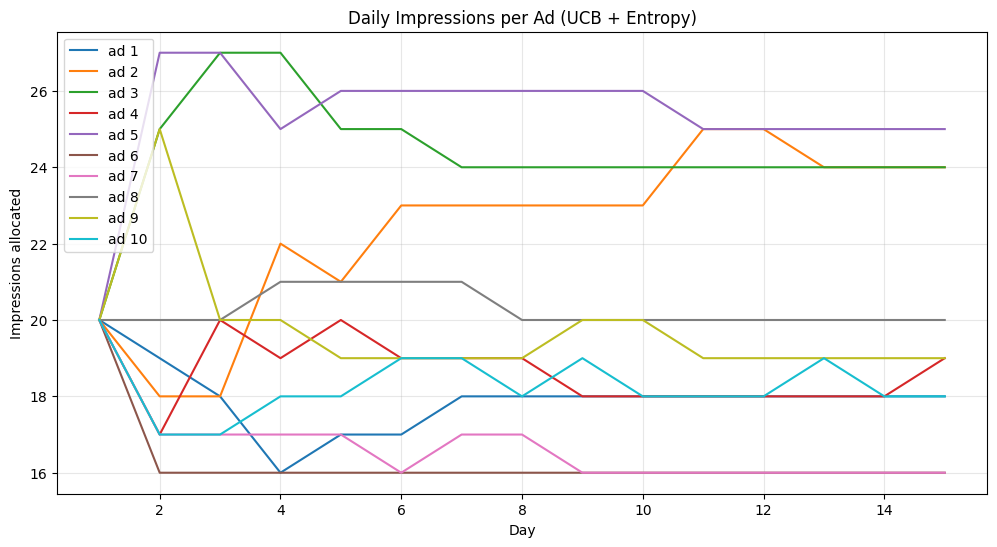

In [233]:
plt.figure(figsize=(12,6))
for ad_id in final_df["ad_id"]:
    ad_hist = alloc_df[alloc_df["ad_id"] == ad_id]
    plt.plot(ad_hist["day"], ad_hist["impressions_today"], label=f"ad {ad_id}")
plt.xlabel("Day")
plt.ylabel("Impressions allocated")
plt.title("Daily Impressions per Ad (UCB + Entropy)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


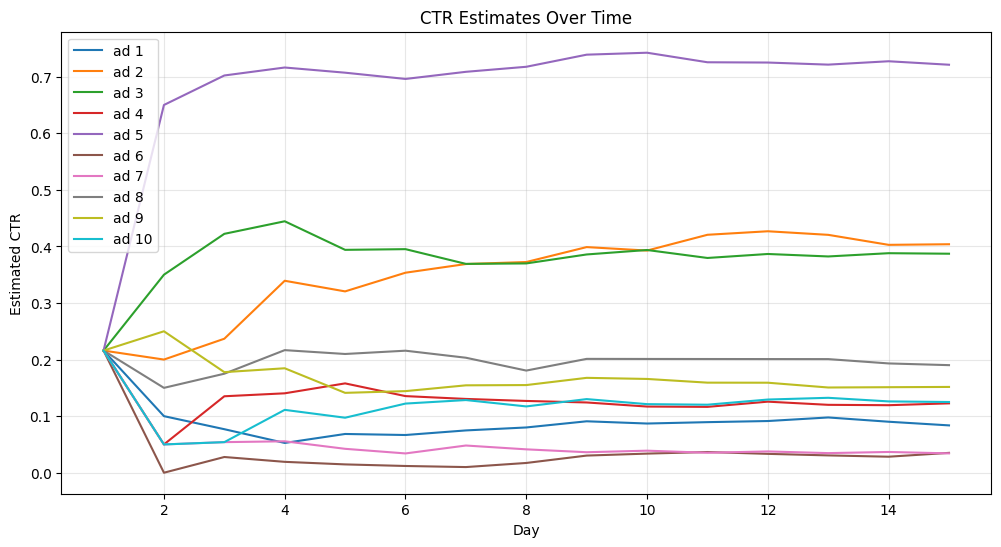

In [234]:
days = est_ctr_hist.shape[0]
ad_ids = final_df["ad_id"].to_numpy()

plt.figure(figsize=(12,6))
for idx, ad_id in enumerate(ad_ids):
    plt.plot(range(1, days+1), est_ctr_hist[:, idx], label=f"ad {ad_id}")
plt.xlabel("Day")
plt.ylabel("Estimated CTR")
plt.title("CTR Estimates Over Time")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
